## This notebook estimates life expectancy using all the 79 variable from CAMS using life expectancy data from 2003 to 2019.

In [1]:
## conda env Weather_Prediction

import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.stats import pearsonr

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler 
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.inspection import permutation_importance
from sklearn.metrics import mean_squared_error

import shap
import os
import geopandas as gpd

pd.set_option('display.precision', 15)
pd.set_option('display.max_columns', None)

In [2]:
full_df=pd.read_pickle('CAMS_with_LEdata.pkl')
full_df

,fips,year,MeanLifeExpectency,10m u-component of wind,10m v-componend of wind,2m dew point temperature,2m temperature,Black carbon AOD at 550 nm,Dust AOD at 550 nm,Land-sea mask,Mean sea level pressure,Organic matter AOD at 550 nm,PM$_1$,PM$_{2.5}$,PM$_{10}$,Sea salt AOD at 550 nm,Sulphate AOD at 550 nm,Surface geopotential,Surface pressure,Total AOD at 469 nm,Total AOD at 550 nm,Total AOD at 670 nm,Total AOD at 865 nm,Total AOD at 1240 nm,Total column carbon monoxide,Total column ethane,Total column formaldehyde,Total column hydrogen peroxide,Total column hydroxyl radical,Total column isoprene,Total column methane,Total column nitric acid,Total column nitrogen dioxide,Total column nitrogen monoxide,Total column ozone,Total column peroxyacetyl nitrate,Total column propane,Total column sulphur dioxide,Total column water vapour,Carbon monoxide,Dust aerosol (0.03-0.55 µm) mixing ratio,Dust aerosol (0.55-0.9 µm) mixing ratio,Dust aerosol (0.9-20 µm) mixing ratio,Ethane,Formaldehyde,Hydrogen peroxide,Hydrophilic black carbon aerosol mixing ratio,Hydrophilic organic matter aerosol mixing ratio,Hydrophobic black carbon aerosol mixing ratio,Hydrophobic organic matter aerosol mixing ratio,Hydroxyl radical,Isoprene,Nitric acid,Nitrogen dioxide,Nitrogen monoxide,Ozone,Peroxyacetyl nitrate,Propane,Sea salt aerosol (0.03-0.5 µm) mixing ratio,Sea salt aerosol (0.5-5 µm) mixing ratio,Sea salt aerosol (5-20 µm) mixing ratio,Specific humidity,Sulphate aerosol mixing ratio,Sulphur dioxide,Temperature,"Leaf area index, high vegetation","Leaf area index, low vegetation",Snow albedo,Snow depth,Total column water,Vertically integrated mass of dust aerosol (0.03-0.55 µm),Vertically integrated mass of dust aerosol (0.55-9 µm),Vertically integrated mass of dust aerosol (9-20 µm),Vertically integrated mass of hydrophilic black carbon aerosol,Vertically integrated mass of hydrophilic organic matter aerosol,Vertically integrated mass of hydrophobic black carbon aerosol,Vertically integrated mass of hydrophobic organic matter aerosol,Vertically integrated mass of sea salt aerosol (0.03-0.5 µm),Vertically integrated mass of sea salt aerosol (0.5-5 µm),Vertically integrated mass of sea salt aerosol (5-20 µm),Vertically integrated mass of sulphate aerosol,Vertically integrated mass of sulphur dioxide,model_level
0,1001,2003,74.628765329999993,0.066413291770766,0.198528113010562,285.629269414872169,290.863352214209158,0.00757124815486,0.010371692890225,0.986464531564209,101746.46078524258337,0.097522246908886,0.000000015615338,0.000000019601377,0.000000027192044,0.00860619294015,0.112170314070482,1368.670051439976305,100086.817007783130975,0.288798537560071,0.236241944078782,0.180380990078313,0.123618863685572,0.069164993038643,0.000984550381998,0.000003862356441,0.000003599970514,0.000008836077454,0.000000004853489,0.000001984446001,0.009753834615672,0.000007246513254,0.000004130302193,0.000000542480041,0.006426156201957,0.000008713431766,0.00000074020297,0.000004737026637,25.902900677695214,0.000000230284119,0.000000000654884,0.000000001134462,0.000000000403961,0.000000000705993,0.000000003513651,0.000000000741261,0.00000000022451,0.000000010096395,0.000000000254529,0.000000005847693,0.000000000000028,0.000000014604292,0.000000001474772,0.000000010235872,0.000000000867748,0.00000005814554,0.000000003056157,0.000000000328437,0.000000000023239,0.000000001862196,0.000000000212949,0.010010040534155,0.00000000404404,0.000000009229008,290.7552046290524,3.904460199286052,2.618741604547198,0.879750469058084,0.000000093784908,26.035876613510123,0.000001993471045,0.00000406255938,0.000003433003025,0.000000147754324,0.000003227288298,0.000000653503172,0.000015866768387,0.000000220848889,0.000017570806448,0.000000962454028,0.000011681476149,0.00000288632888,<NA>
1,1003,2003,76.661419230000007,-0.356848371194803,0.230961128028523,289.075082204243699,292.904504754344714,0.007386436848696,0.012786048677104,0.422456727373741,101714.38567138351209,0.080536809563287,0.000000

In [3]:
full_df = full_df.drop(['fips', 'year','model_level'], axis=1)
full_df

,MeanLifeExpectency,10m u-component of wind,10m v-componend of wind,2m dew point temperature,2m temperature,Black carbon AOD at 550 nm,Dust AOD at 550 nm,Land-sea mask,Mean sea level pressure,Organic matter AOD at 550 nm,PM$_1$,PM$_{2.5}$,PM$_{10}$,Sea salt AOD at 550 nm,Sulphate AOD at 550 nm,Surface geopotential,Surface pressure,Total AOD at 469 nm,Total AOD at 550 nm,Total AOD at 670 nm,Total AOD at 865 nm,Total AOD at 1240 nm,Total column carbon monoxide,Total column ethane,Total column formaldehyde,Total column hydrogen peroxide,Total column hydroxyl radical,Total column isoprene,Total column methane,Total column nitric acid,Total column nitrogen dioxide,Total column nitrogen monoxide,Total column ozone,Total column peroxyacetyl nitrate,Total column propane,Total column sulphur dioxide,Total column water vapour,Carbon monoxide,Dust aerosol (0.03-0.55 µm) mixing ratio,Dust aerosol (0.55-0.9 µm) mixing ratio,Dust aerosol (0.9-20 µm) mixing ratio,Ethane,Formaldehyde,Hydrogen peroxide,Hydrophilic black carbon aerosol mixing ratio,Hydrophilic organic matter aerosol mixing ratio,Hydrophobic black carbon aerosol mixing ratio,Hydrophobic organic matter aerosol mixing ratio,Hydroxyl radical,Isoprene,Nitric acid,Nitrogen dioxide,Nitrogen monoxide,Ozone,Peroxyacetyl nitrate,Propane,Sea salt aerosol (0.03-0.5 µm) mixing ratio,Sea salt aerosol (0.5-5 µm) mixing ratio,Sea salt aerosol (5-20 µm) mixing ratio,Specific humidity,Sulphate aerosol mixing ratio,Sulphur dioxide,Temperature,"Leaf area index, high vegetation","Leaf area index, low vegetation",Snow albedo,Snow depth,Total column water,Vertically integrated mass of dust aerosol (0.03-0.55 µm),Vertically integrated mass of dust aerosol (0.55-9 µm),Vertically integrated mass of dust aerosol (9-20 µm),Vertically integrated mass of hydrophilic black carbon aerosol,Vertically integrated mass of hydrophilic organic matter aerosol,Vertically integrated mass of hydrophobic black carbon aerosol,Vertically integrated mass of hydrophobic organic matter aerosol,Vertically integrated mass of sea salt aerosol (0.03-0.5 µm),Vertically integrated mass of sea salt aerosol (0.5-5 µm),Vertically integrated mass of sea salt aerosol (5-20 µm),Vertically integrated mass of sulphate aerosol,Vertically integrated mass of sulphur dioxide
0,74.628765329999993,0.066413291770766,0.198528113010562,285.629269414872169,290.863352214209158,0.00757124815486,0.010371692890225,0.986464531564209,101746.46078524258337,0.097522246908886,0.000000015615338,0.000000019601377,0.000000027192044,0.00860619294015,0.112170314070482,1368.670051439976305,100086.817007783130975,0.288798537560071,0.236241944078782,0.180380990078313,0.123618863685572,0.069164993038643,0.000984550381998,0.000003862356441,0.000003599970514,0.000008836077454,0.000000004853489,0.000001984446001,0.009753834615672,0.000007246513254,0.000004130302193,0.000000542480041,0.006426156201957,0.000008713431766,0.00000074020297,0.000004737026637,25.902900677695214,0.000000230284119,0.000000000654884,0.000000001134462,0.000000000403961,0.000000000705993,0.000000003513651,0.000000000741261,0.00000000022451,0.000000010096395,0.000000000254529,0.000000005847693,0.000000000000028,0.000000014604292,0.000000001474772,0.000000010235872,0.000000000867748,0.00000005814554,0.000000003056157,0.000000000328437,0.000000000023239,0.000000001862196,0.000000000212949,0.010010040534155,0.00000000404404,0.000000009229008,290.7552046290524,3.904460199286052,2.618741604547198,0.879750469058084,0.000000093784908,26.035876613510123,0.000001993471045,0.00000406255938,0.000003433003025,0.000000147754324,0.000003227288298,0.000000653503172,0.000015866768387,0.000000220848889,0.000017570806448,0.000000962454028,0.000011681476149,0.00000288632888
1,76.661419230000007,-0.356848371194803,0.230961128028523,289.075082204243699,292.904504754344714,0.007386436848696,0.012786048677104,0.422456727373741,101714.38567138351209,0.080536809563287,0.000000010517524,0.000000014405518,0.000000020184934,0

In [4]:
## Lets create a Train-Test set

features=full_df.drop('MeanLifeExpectency',axis=1)
target=full_df['MeanLifeExpectency'].copy()

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.20) 

In [5]:
## initial results

forest_reg=RandomForestRegressor()
forest_reg.fit(X_train, y_train)

train_prediction=forest_reg.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.42


In [6]:
## lets do a cross-validation to identify overfitting and test if there is variation in the output result,
## based on variability of the input data

scores=cross_val_score(forest_reg, X_train, y_train,
                        scoring='neg_mean_squared_error', cv=10, n_jobs=6) ## can select other scoring as well
                                                                          ## n_jobs uses the number of cores
rmse_scores=np.sqrt(-scores)
sd_rmse=rmse_scores.std()
avg_score=rmse_scores.mean()

In [7]:
print(f'RMSE scores for each fold: {rmse_scores}')
print(f'Mean RMSE score: {avg_score}')
print(f'Standard deviation of RMSE scores: {sd_rmse}')

RMSE scores for each fold: [1.06179121 1.17590525 1.15453502 1.12437455 1.18122976 1.17898076
 1.16325488 1.17949104 1.18323047 1.19075572]
Mean RMSE score: 1.159354865449619
Standard deviation of RMSE scores: 0.03725567749584312


In [8]:
%%time
## lets optimize the hyperparameters
forest_reg=RandomForestRegressor(n_jobs=-1, oob_score=True) ## also include oob score. this can be removed if not necessary

hyper_parameters=[{'n_estimators':[200, 300],'max_features': [10,20], 'max_depth':[100, 150],
                                                              'min_samples_split':[ 10, 20]}]
grid_search=GridSearchCV(forest_reg,hyper_parameters,cv=4,scoring="neg_mean_squared_error",return_train_score=True, verbose=1)
grid_search.fit(X_train,y_train)

Fitting 4 folds for each of 16 candidates, totalling 64 fits
CPU times: total: 3h 20min 35s
Wall time: 14min 34s


GridSearchCV(cv=4, estimator=RandomForestRegressor(n_jobs=-1, oob_score=True),
             param_grid=[{'max_depth': [100, 150], 'max_features': [10, 20],
                          'min_samples_split': [10, 20],
                          'n_estimators': [200, 300]}],
             return_train_score=True, scoring='neg_mean_squared_error',
             verbose=1)

In [9]:
grid_search.best_estimator_

RandomForestRegressor(max_depth=150, max_features=20, min_samples_split=10,
                      n_estimators=300, n_jobs=-1, oob_score=True)

In [10]:
## lets now select the model. This will be used later
final_model=grid_search.best_estimator_

In [11]:
## fit the model and find the error in the traning set

final_model.fit(X_train,y_train)

train_prediction=final_model.predict(X_train)

mse_train=mean_squared_error(y_train, train_prediction)
rmse_train=np.sqrt(mse_train)
rmse_train=int(rmse_train*100)/100 ## display only two digits without rounding

print('The train RMSE :::', '%.2f' % rmse_train)

The train RMSE ::: 0.69


In [12]:
oob_score=final_model.oob_score_
print(f'OOB score is: {oob_score:.2}') ## oob_score_ is calucalated as R$^2$ between true and estimated 

OOB score is: 0.74


In [13]:
## The test prediction

test_prediction=final_model.predict(X_test)

mse_test=mean_squared_error(y_test,test_prediction)
rmse_test=np.sqrt(mse_test)
rmse_test=int(rmse_test*100)/100 

print('The test RMSE :::', '%.2f' % rmse_test)

The test RMSE ::: 1.23


In [14]:
## the train r square

train_r_sq=(pearsonr(y_train,train_prediction)[0])**2
corr_train=int(train_r_sq*100)/100 ## display only two digits without rounding

print('The train r_sq :::', '%.2f' % corr_train)

The train r_sq ::: 0.92


In [15]:
## The test r square

test_r_sq=(pearsonr(y_test,test_prediction)[0])**2
corr_test=int(test_r_sq*100)/100 ## display only two digits without rounding

print('The test r_sq :::', '%.2f' % corr_test)

The test r_sq ::: 0.74


In [16]:
## calculate the adjusted r square

## in training set

n_train=X_train.shape[0] ## number of samples in training set
n_test=X_test.shape[0]  ## number of samples in test set
p=X_train.shape[1] ## number of features, which is the same in train and test set

train_adjusted_r2=1-(1-corr_train)*((n_train-1)/(n_train-p-1))
train_adjusted_r2=int(train_adjusted_r2*100)/100 ## display only two digits without rounding

test_adjusted_r2=1-(1-corr_test)*((n_test-1)/(n_test-p-1))
test_adjusted_r2=int(test_adjusted_r2*100)/100 ## display only two digits without rounding

print('The adjusted train r_sq :::', '%.2f' % train_adjusted_r2)
print('The adjusted test r_sq :::', '%.2f' % test_adjusted_r2)

The adjusted train r_sq ::: 0.91
The adjusted test r_sq ::: 0.73


In [17]:
## steps to convert train and test to pandas dataframe. This step is necessary to plot in seaborn

y_train_np=y_train.to_numpy() ## convert dtype to numpy to plot from seaborn
y_test_np=y_test.to_numpy() 

df1=pd.DataFrame(y_train_np, columns=['Actual'])
df2=pd.DataFrame(train_prediction, columns=['Estimated'])
df3=pd.concat([df1, df2],axis=1)  ## concatenate the columns
df3['Label']='Train'

df4=pd.DataFrame(y_test_np, columns=['Actual'])
df5=pd.DataFrame(test_prediction, columns=['Estimated'])
df6=pd.concat([df4, df5],axis=1)
df6['Label']='Test'

sns_df=pd.concat([df3,df6])

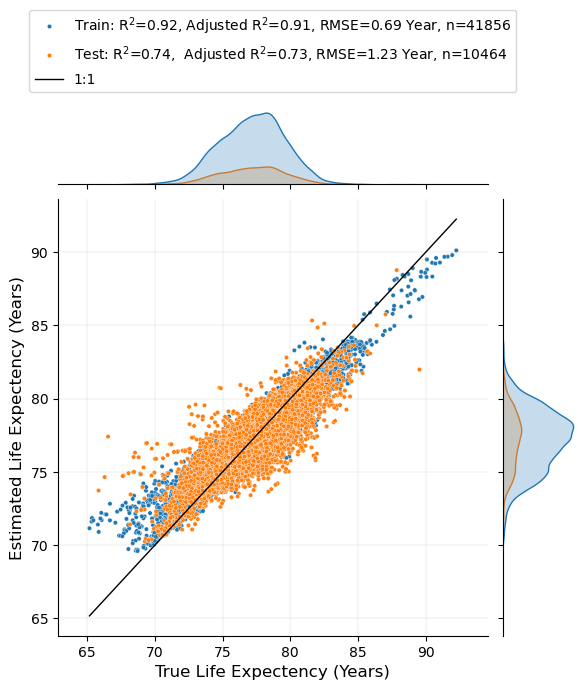

In [18]:
## scatter plot in seaborn

g=sns.jointplot(data=sns_df, x='Actual', y='Estimated', kind="scatter", hue='Label',s=10)
plt.grid(axis='both',linewidth=0.15)

p1 = max(max(train_prediction), max(y_train))
p2 = min(min(train_prediction), min(y_train))

g.ax_joint.plot([p1, p2], [p1, p2], color='k',linewidth=1, label='1:1')

# Customize the legend
handles, labels = g.ax_joint.get_legend_handles_labels()  



g.ax_joint.legend(handles=handles,  
    labels=[ f'Train: R$^2$={corr_train}, Adjusted R$^2$={train_adjusted_r2}, RMSE={rmse_train} Year, n={len(X_train)}', 
        f'Test: R$^2$={corr_test},  Adjusted R$^2$={test_adjusted_r2}, RMSE={rmse_test} Year, n={len(X_test)}','1:1'],
                        title=None)

sns.move_legend(g.ax_joint, "upper center", bbox_to_anchor=(0.5, 1.45))

g.set_axis_labels(r'True Life Expectency (Years)', r'Estimated Life Expectency (Years)',fontsize=12)

plt.show()

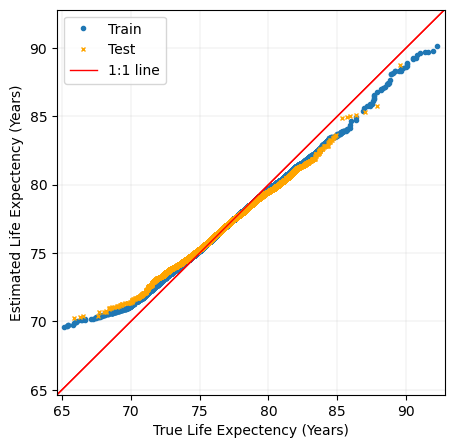

In [19]:
## Lets plot the quantile-quantile plot

fig, ax = plt.subplots(figsize=(5,5))

pp_x = sm.ProbPlot(y_train, fit=False)
pp_y = sm.ProbPlot(train_prediction, fit=False)


qq = pp_y.qqplot(marker='o',markersize=3,other=pp_x,ax=ax, label='Train') ## qq plot for train data
sm.qqline(ax=ax, line='45', fmt='r',linewidth=1)

pp_xx = sm.ProbPlot(y_test, fit=False)
pp_yy = sm.ProbPlot(test_prediction, fit=False)

## overlay qq plot for test data
qqq = pp_yy.qqplot(xlabel='True Life Expectency (Years)',ylabel='Estimated Life Expectency (Years)',
                            marker='x',markersize=3,other=pp_xx,ax=ax,markeredgecolor = 'orange',
                                      markerfacecolor = 'orange', label='Test')

sm.qqline(qq.axes[0], line='45', fmt='r',linewidth=1, label='1:1 line')
plt.grid(axis='both',linewidth=0.15)
plt.legend()
plt.show()

In [20]:
train_permutation = permutation_importance(final_model, X_train, y_train, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5

In [21]:
mean_val=train_permutation['importances_mean'] ## mean feature importance
std_value=train_permutation['importances_std'] ## standard deviation after shuffling 9 times
feature_names=X_train.columns  ## get features names

mean_importance=sorted(zip(mean_val, feature_names), reverse=True) 
std_importance=sorted(zip(std_value, feature_names), reverse=True)

In [22]:
mean_imp = pd.DataFrame(mean_val, columns=['Mean Weight'])
std_imp = pd.DataFrame(std_value, columns=['Standard Deviation'])
feature_names=list(features.columns.values) ## get list of features as list
feature_df = pd.DataFrame(feature_names, columns=['Feature'])
train_FI = pd.concat([feature_df,mean_imp, std_imp ], axis=1) 
# Sort in descending order
train_FI = train_FI.sort_values(['Mean Weight'], ascending=[False])

print(train_FI)

                                          Feature            Mean Weight  \
63                Leaf area index, low vegetation  1.481491817609435e-01   
62               Leaf area index, high vegetation  1.310811209190555e-01   
6                                   Land-sea mask  1.106068623438580e-01   
2                        2m dew point temperature  1.069703078655607e-01   
58                              Specific humidity  1.064716467860796e-01   
..                                            ...                    ...   
41                                   Formaldehyde  1.233581138472396e-17   
60                                Sulphur dioxide  1.233581138472396e-17   
45  Hydrophobic black carbon aerosol mixing ratio  0.000000000000000e+00   
42                              Hydrogen peroxide  0.000000000000000e+00   
57        Sea salt aerosol (5-20 µm) mixing ratio  0.000000000000000e+00   

       Standard Deviation  
63  1.410843039273152e-03  
62  8.527516442844145e-04  
6  

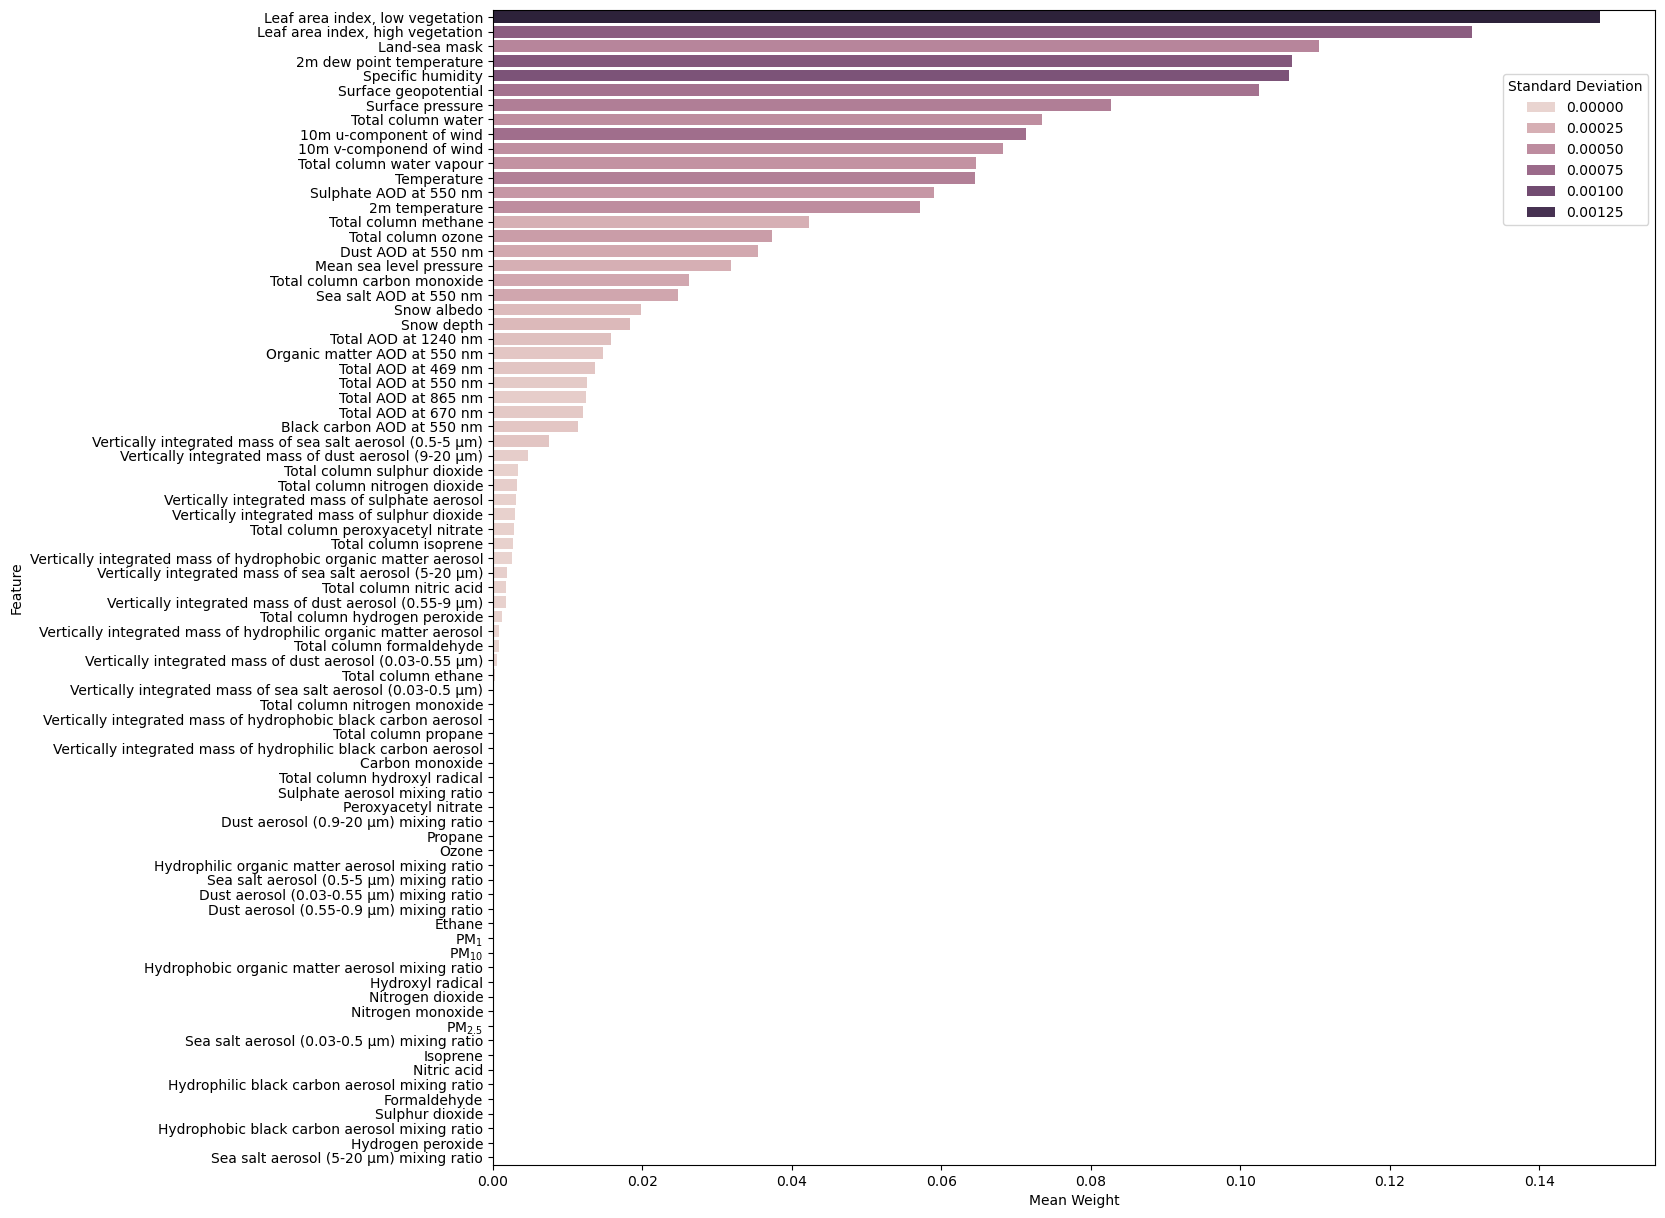

In [23]:
fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(train_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')

sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))

In [24]:
test_permutation = permutation_importance(final_model, X_test, y_test, 
                                            n_jobs=6, ## number of cores to run
                                             n_repeats=9) ## number of times to shuffle, default is 5

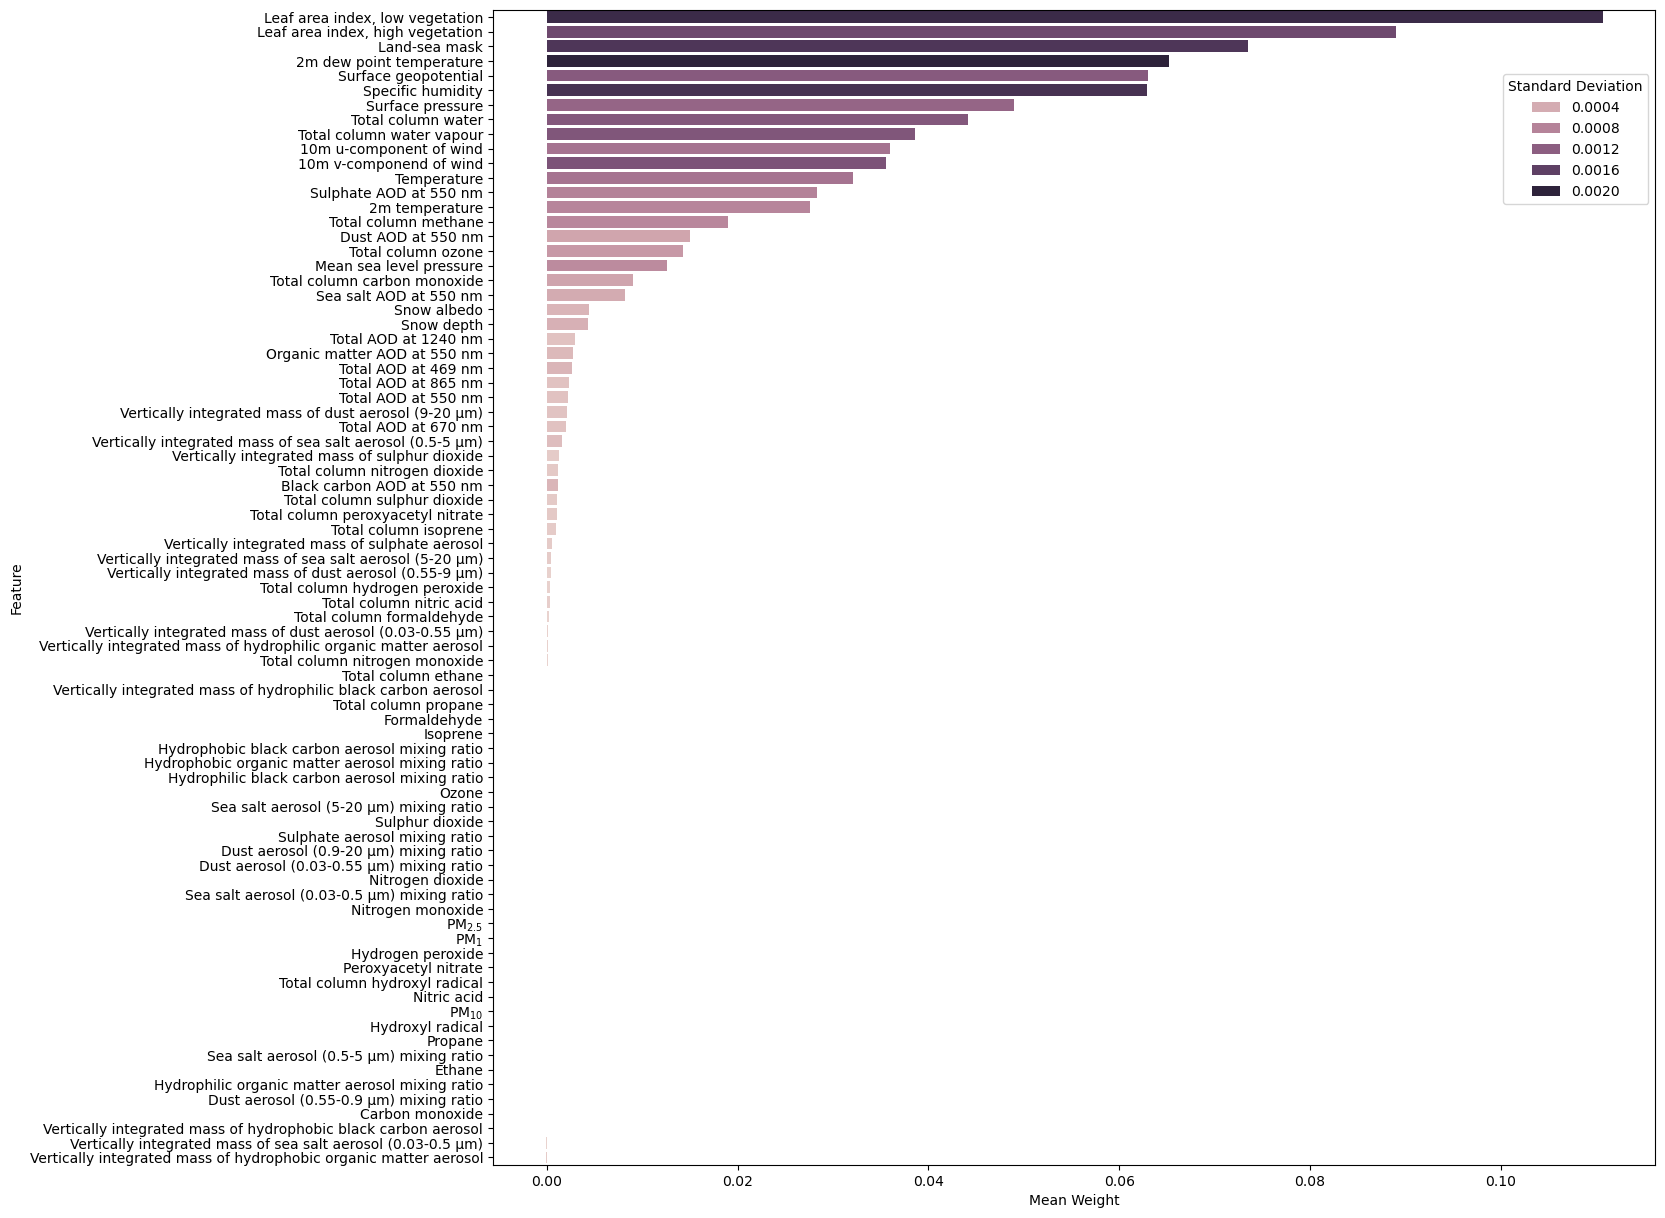

In [25]:
mean_val_test=test_permutation['importances_mean'] ## mean feature importance
std_value_test=test_permutation['importances_std'] ## standard deviation after shuffling 9 times

mean_imp_test = pd.DataFrame(mean_val_test, columns=['Mean Weight'])
std_imp_test = pd.DataFrame(std_value_test, columns=['Standard Deviation'])
feature_names=list(features.columns.values)
feature_df = pd.DataFrame(feature_names, columns=['Feature'])

test_FI = pd.concat([feature_df,mean_imp_test, std_imp_test ], axis=1) 
# Sort in descending order
test_FI = test_FI.sort_values(['Mean Weight'], ascending=[False])

fig, ax = plt.subplots(figsize=(15, 15))
sns.barplot(test_FI, x="Mean Weight", y='Feature', hue='Standard Deviation')
sns.move_legend(ax, "upper right", bbox_to_anchor=(1, 0.95))